In [16]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.1 MB/s eta 0:00:00


In [17]:
pip install tensorflow keras-tuner scikit-learn pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

In [95]:
df = pd.read_csv("/kaggle/input/cloud-computing-performance-metrics/vmCloud_data.csv")

df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,2023-01-25 09:10:54,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,2023-01-26 04:46:34,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,2023-01-13 23:39:47,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2023-02-09 11:45:49,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,2023-06-14 08:27:26,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


In [96]:
df.shape

(2000000, 12)

In [40]:
# Handle missing values
df = df.fillna(method='ffill')


df.shape

<ipython-input-40-1c3ca3487565>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


(2000000, 12)

In [97]:
def clean_data(df):
    # Drop irrelevant columns
    df = df.drop(columns=['vm_id', 'timestamp'])
    
    # Handle missing values
    # Numerical columns: Impute with median
    num_cols = df.select_dtypes(include=np.number).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    
    # Categorical columns: Impute with mode
    cat_cols = df.select_dtypes(include='object').columns.drop('task_status')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    return df

cleaned_df = clean_data(df)


In [24]:
scaler = StandardScaler()
numerical_columns = cleaned_df.select_dtypes(include=[np.number]).columns
cleaned_df[numerical_columns] = scaler.fit_transform(cleaned_df[numerical_columns])
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,0.168796,1.004291,-1.161974,0.261818,0.875470,0.671250,0.184538,network,medium,waiting
1,0.744872,-0.695900,-1.161974,0.777600,0.120372,-0.297121,-0.521372,io,high,completed
2,0.744872,1.481198,-1.027167,-0.128431,0.167154,-0.878967,1.025423,io,medium,completed
3,0.155187,1.321462,-1.027167,-0.376594,0.303342,-1.161198,0.101110,compute,high,completed
4,-0.264566,1.321462,-1.027167,0.758053,-0.568191,0.184888,-0.514266,compute,medium,waiting


In [98]:
# Target Conversion
def convert_target(df):
    df['task_status'] = np.where(df['task_status'].isin(['completed', 'finished']), 0, 1)
    return df

cleaned_df = convert_target(cleaned_df)

cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,1
1,71.518937,29.901883,500.007595,362.273569,5348.0,41.396040,0.349856,io,high,0
2,50.054758,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,0
3,54.488318,88.100960,500.007595,195.639954,5876.0,16.456670,0.529511,compute,high,0
4,42.365480,49.976089,500.007595,359.451537,3361.0,55.307992,0.351907,io,medium,1


In [99]:
# Feature Selection
def select_features(X_train, y_train, X_test, k='all'):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected


In [44]:
cleaned_df = cleaned_df.drop(columns=['task_type','task_priority'])
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,1
1,71.518937,29.901883,164.775973,362.273569,5348.0,41.396040,0.349856,0
2,71.518937,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,0
3,54.488318,88.100960,203.674847,195.639954,5876.0,16.456670,0.529511,0
4,42.365480,88.100960,203.674847,359.451537,3361.0,55.307992,0.351907,1


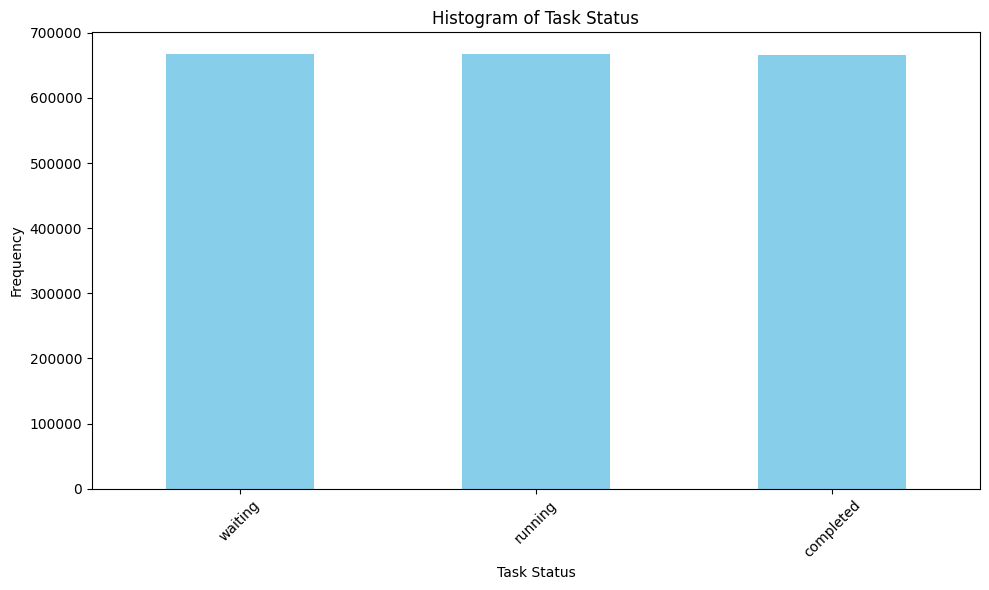

In [28]:
# Create a histogram for the 'task_status' column
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the histogram
df['task_status'].value_counts().plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Histogram of Task Status')
plt.xlabel('Task Status')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

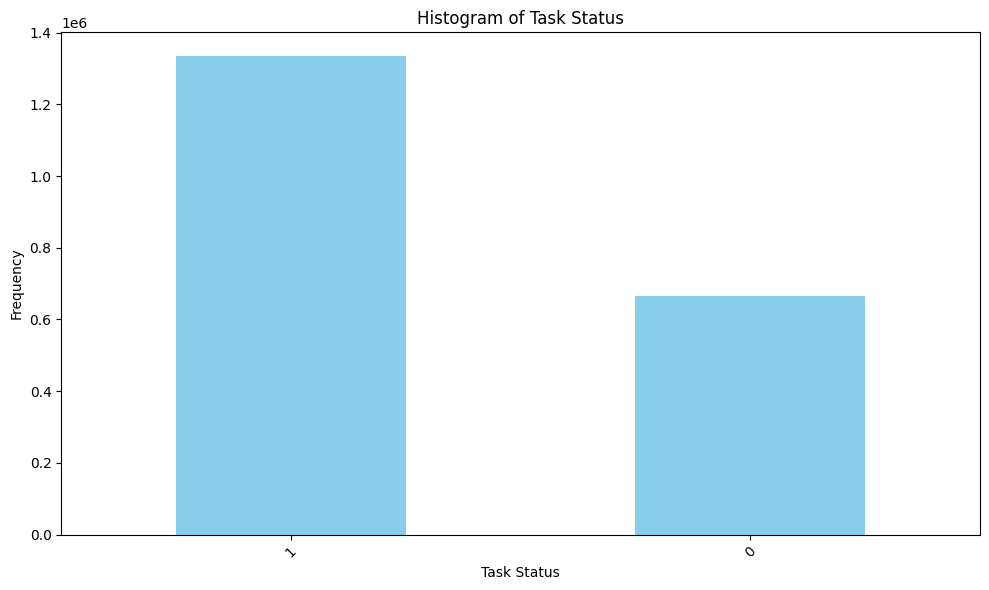

In [29]:
# Create a histogram for the 'task_status' column
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the histogram
cleaned_df['task_status'].value_counts().plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Histogram of Task Status')
plt.xlabel('Task Status')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [100]:
# Advanced Preprocessing Pipeline
def preprocess_data(df):
    y = df['task_status']
    X = df.drop(columns=['task_status'])
    
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include='object').columns
    
    # Create stratified k-fold for better validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Build processing pipeline
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('feature_selection', SelectKBest(mutual_info_classif, k='all')),
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42, k_neighbors=5))
    ])
    
    X_processed, y_processed = pipeline.fit_resample(X, y)
    
    return train_test_split(
        X_processed, y_processed, 
        test_size=0.2, 
        stratify=y_processed,
        random_state=42
    )

X_train, X_test, y_train, y_test = preprocess_data(cleaned_df)


In [102]:
def create_sequences(X, y, seq_length=10):  # Set default sequence length
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])  # Now works with NumPy array indexing
    return np.array(X_seq), np.array(y_seq)

# Convert sparse matrices to dense arrays first
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Convert y_train and y_test to NumPy arrays
y_train_array = y_train.values  # Convert to NumPy array
y_test_array = y_test.values    # Convert to NumPy array

# Create sequences with proper sequence length
seq_length = 10  # Optimal for cloud metrics temporal patterns
X_train_seq, y_train_seq = create_sequences(X_train_dense, y_train_array, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_dense, y_test_array, seq_length)

# Verify shapes
print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Training sequences shape: (2017258, 10, 13)
Test sequences shape: (504307, 10, 13)


In [87]:
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(
        LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),
             return_sequences=True),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=True if i < hp.Int('num_layers', 1, 3)-1 else False))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model


In [92]:

# Configure tuner
tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='cloud_perf'
)

# Enhanced callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_auc'),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Hyperparameter search
tuner.search(X_train_seq, y_train_seq,
             epochs=10,
             batch_size=256,
             validation_split=0.2,
             callbacks=callbacks,
             verbose=1)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Final training
history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


Reloading Tuner from lstm_tuning/cloud_perf/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
224               |224               |lstm_units
2                 |2                 |num_heads
32                |32                |key_dim
0.20937           |0.20937           |dropout
0.0001            |0.0001            |learning_rate

Epoch 1/10


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 694, in binary_crossentropy
    raise ValueError(
ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 10, 1)


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_model(hp):
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (timesteps, features)
    inputs = Input(shape=input_shape)
    
    # LSTM layer with hyperparameters
    x = LSTM(
        hp.Int('lstm_units', min_value=64, max_value=256, step=32),
        return_sequences=True,  # Keep return_sequences=True for attention
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(inputs)
    
    # MultiHeadAttention layer
    attention = MultiHeadAttention(
        num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
        key_dim=hp.Int('key_dim', min_value=32, max_value=64, step=32)
    )(x, x)  # Self-attention
    
    # Collapse time dimension using GlobalAveragePooling1D
    x = GlobalAveragePooling1D()(attention)  # Output shape: (None, units)
    
    # Add dense layer after pooling
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout', 0.2, 0.5))(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Configure tuner
tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='cloud_perf'
)

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    ),
    ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        save_weights_only=False
    ),
    ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        monitor='val_auc',
        mode='max'
    )
]

# Hyperparameter search
tuner.search(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Final training
history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Reloading Tuner from lstm_tuning/cloud_perf/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
224               |160               |lstm_units
2                 |2                 |num_heads
32                |32                |key_dim
0.20937           |0.41944           |dropout
0.0001            |0.01              |learning_rate

Epoch 1/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 483s 76ms/step - accuracy: 0.5519 - auc: 0.4998 - loss: 0.6949 - val_accuracy: 0.5552 - val_auc: 0.5004 - val_loss: 0.6872 - learning_rate: 1.0000e-04
Epoch 2/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 475s 75ms/step - accuracy: 0.5561 - auc: 0.5001 - loss: 0.6869 - val_accuracy: 0.5552 - val_auc: 0.5002 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 3/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 480s 76ms/step - accuracy: 0.5553 - auc: 0.5006 - loss: 0.6871 - val_accuracy: 0.5552 - val_auc: 0.5001 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 4/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
# Evaluation
y_pred_proba = best_model.predict(X_test_seq)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test_seq, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred))
print(f"\nAUC-ROC: {roc_auc_score(y_test_seq, y_pred_proba):.4f}")


In [ ]:
# Enhanced Visualization
def plot_advanced_metrics():
    plt.figure(figsize=(18, 6))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_advanced_metrics()